# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


In [1]:
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [2]:
def simulate_data(background_noise, fps = 30, n_cells = 100):

    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = 5 # the peak firing rate, averaged across the population 
    n_cells = n_cells 
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
        
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = fps
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps


    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = background_noise # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    return true_firing_rate_maps, spikes, t, x, pf_centers

def get_firing_rate_maps(binning, spike_positions, x, n_cells = 200, fps=30):

    space_bins = np.arange(0., float(n_cells), float(binning))
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy 
    return firing_rate_maps, occupancy, space_bins

def plot_firing_rate_maps(firing_rate_maps, n_cells, track_length, title):

    plt.figure(figsize=(15,5))
    plt.title(title)
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, track_length, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    plt.show()
    plt.close()

In [3]:
fps = 30 # the number of "video frames" per second 
n_cells = 100 # how many cells we are recording

true_firing_rate_maps, spikes, t, x, _ = simulate_data(background_noise=0.1, fps = fps, n_cells = n_cells)

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


100


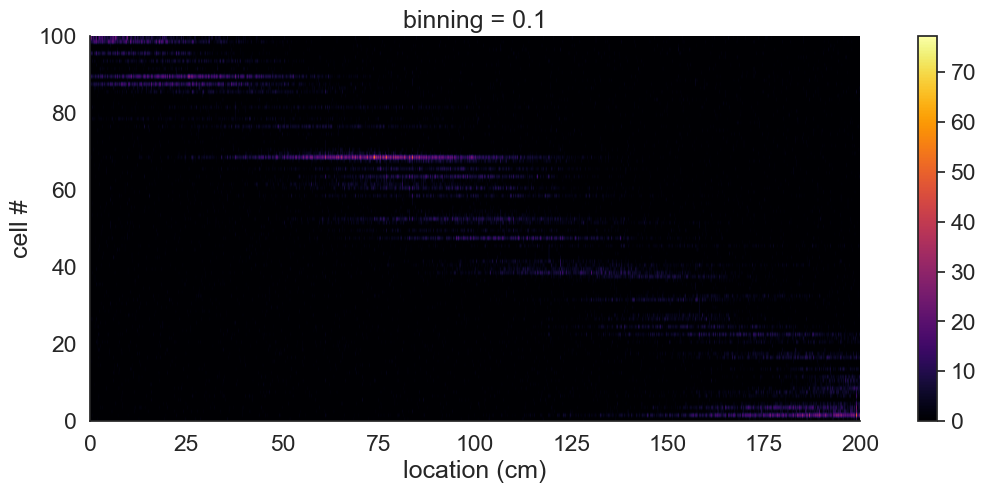

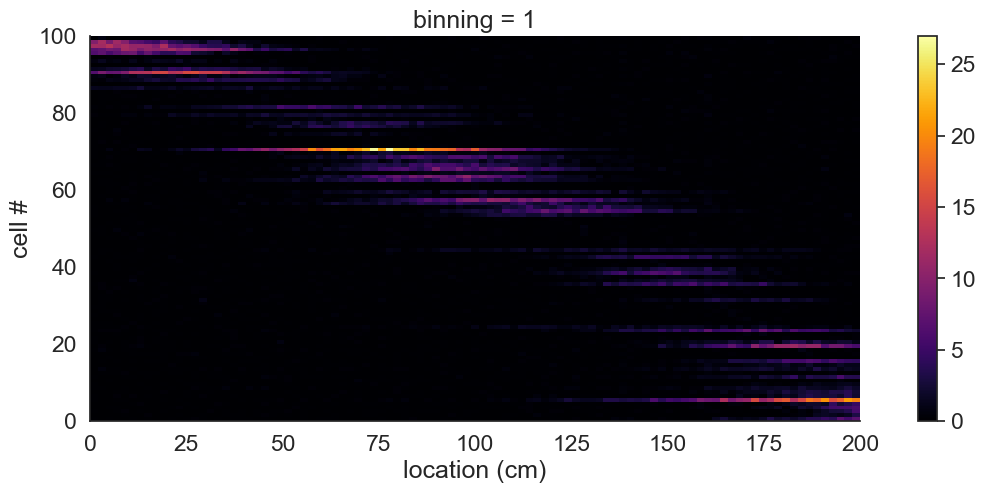

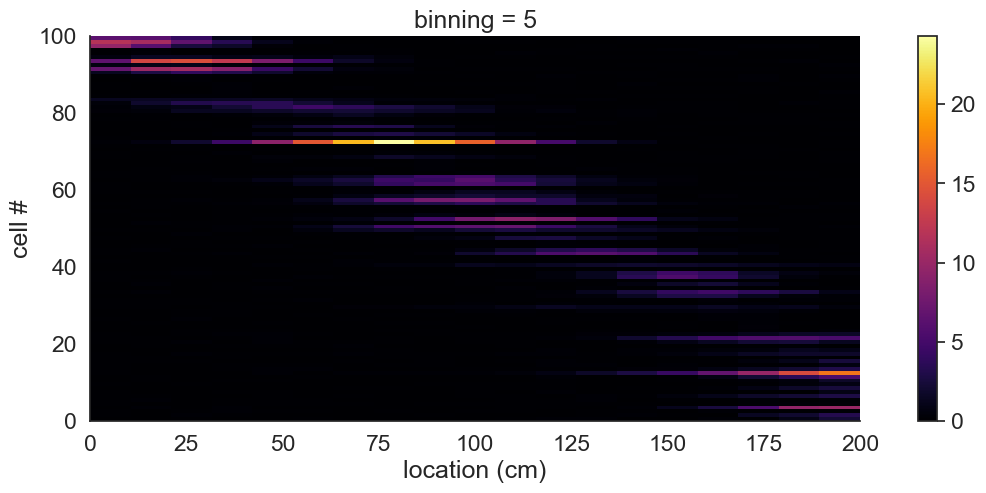

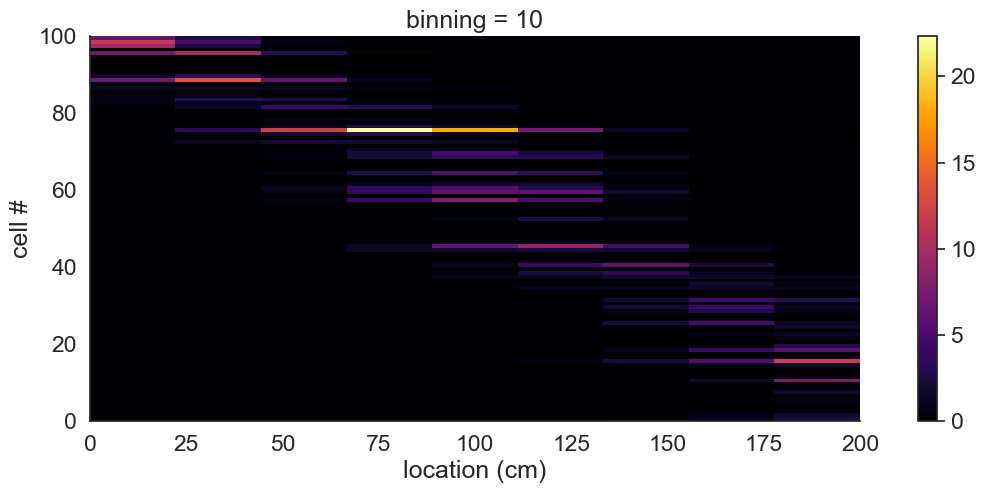

In [4]:

spike_positions = [np.interp(s, t, x) for s in spikes]

print(len(spike_positions))

## (A) Make binning broader and coarser
for binning in (.1,1,5,10):
    
    firing_rate_maps, occupancy, _ = get_firing_rate_maps(binning, spike_positions, x, n_cells, fps=fps)
    plot_firing_rate_maps(firing_rate_maps, n_cells, track_length = 200, title = f'binning = {binning}')


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


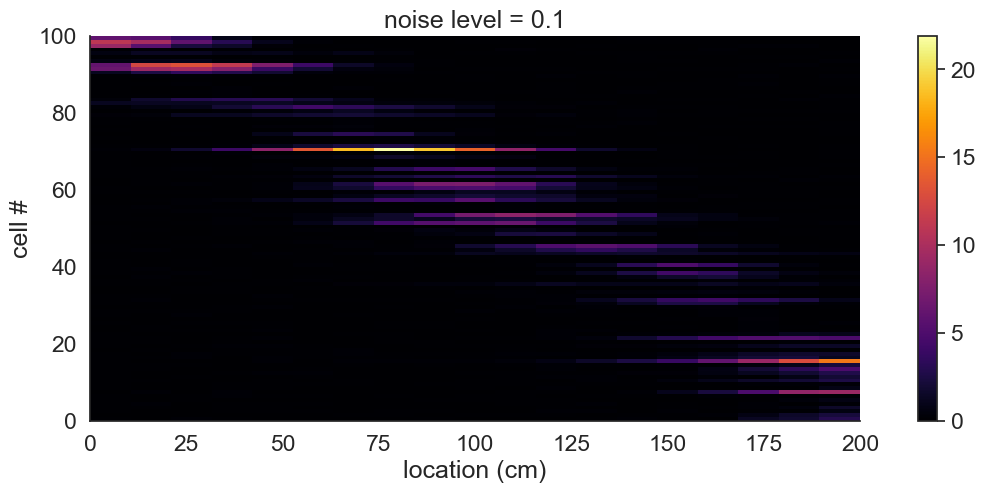

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


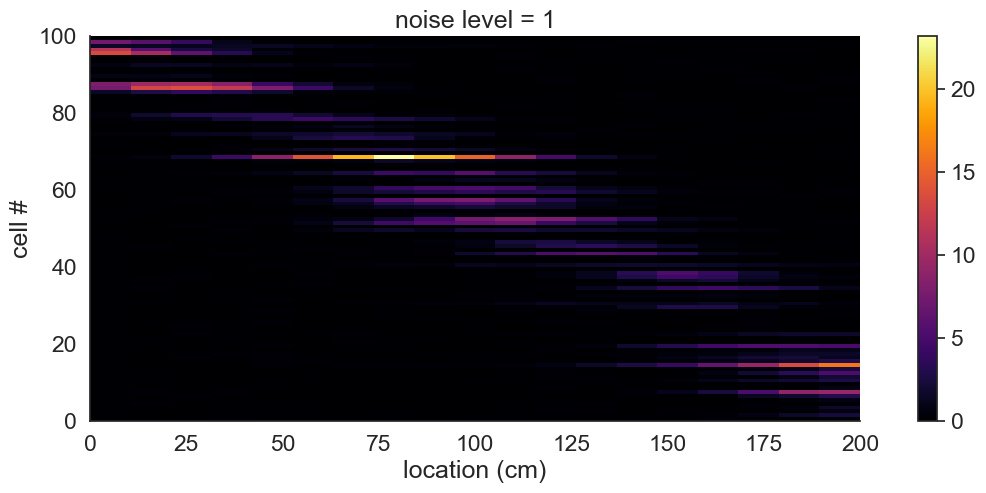

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


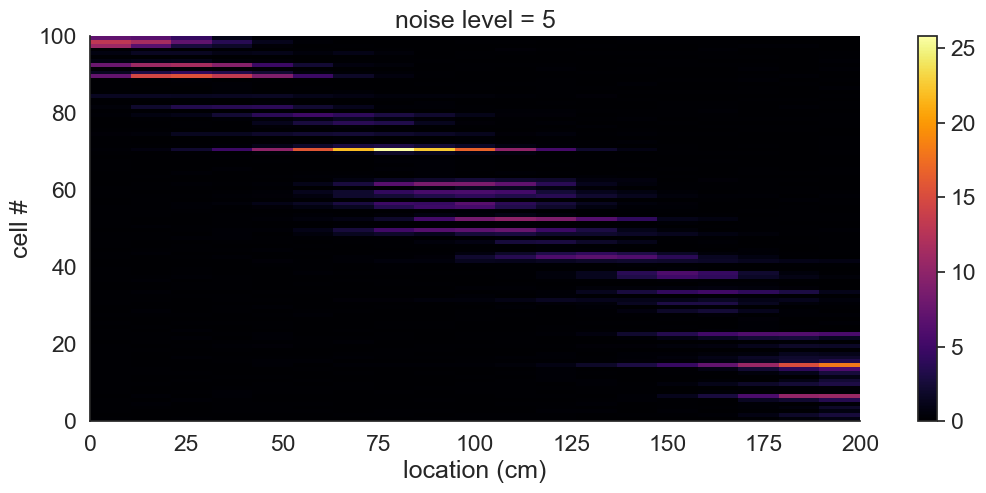

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


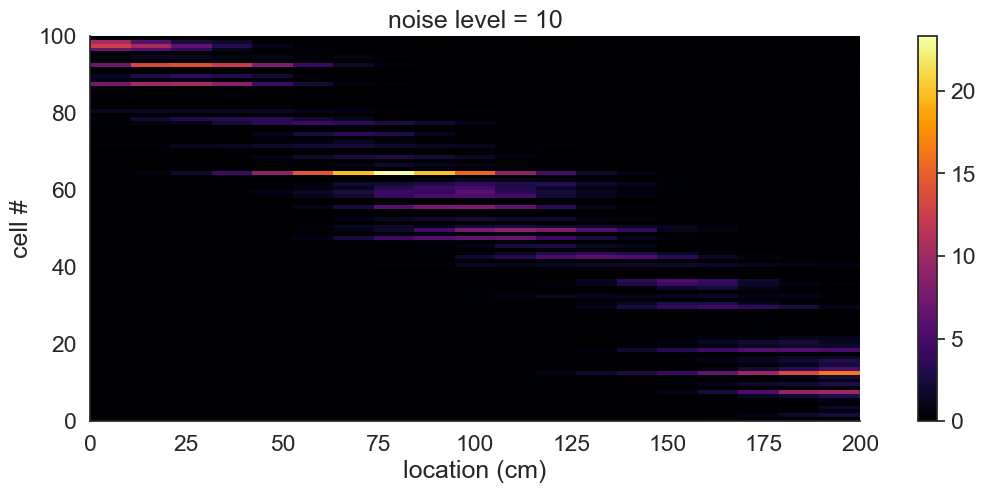

In [5]:
# (B) Change Noise levels:

binning = 5

for background_noise in (.1,1,5,10):
    true_firing_rate_maps, spikes, t, x, _ = simulate_data(background_noise=background_noise, fps = fps, n_cells = n_cells)
    firing_rate_maps, occupancy, _ = get_firing_rate_maps(binning, spike_positions, x, n_cells, fps=fps)
    plot_firing_rate_maps(firing_rate_maps, n_cells, track_length = 200, title = f'noise level = {background_noise}')

(A) Reducing the binning broadness results in higher resolution for the place cells but is also connected to higher susceptibility to noise. However, reducing it too much results in not finding any place fields because most bins will not contain any spikes.

(B) With high noise, the place cells become more visible when using a larger bin size.

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


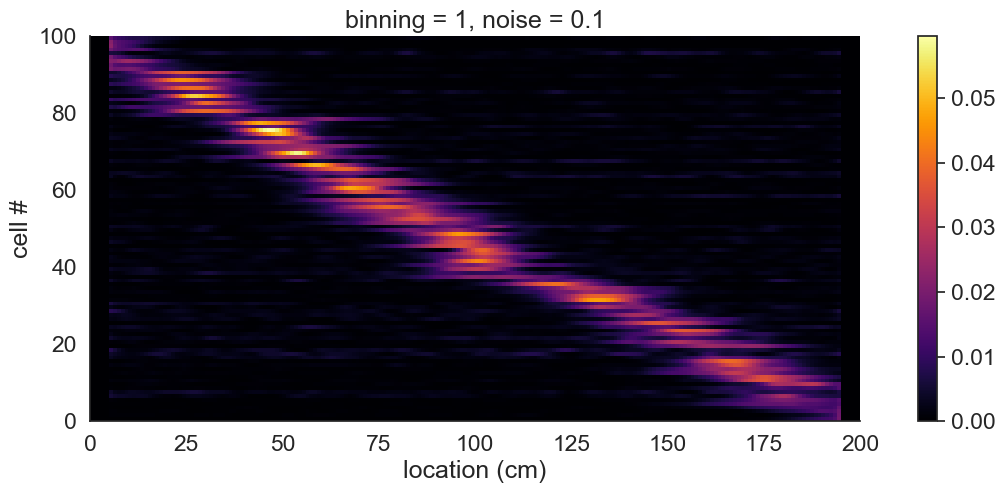

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


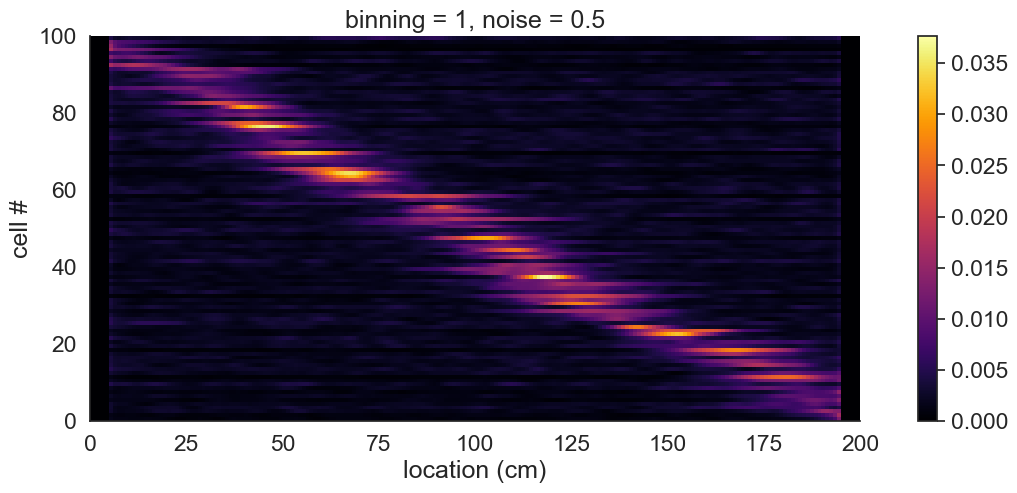

100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


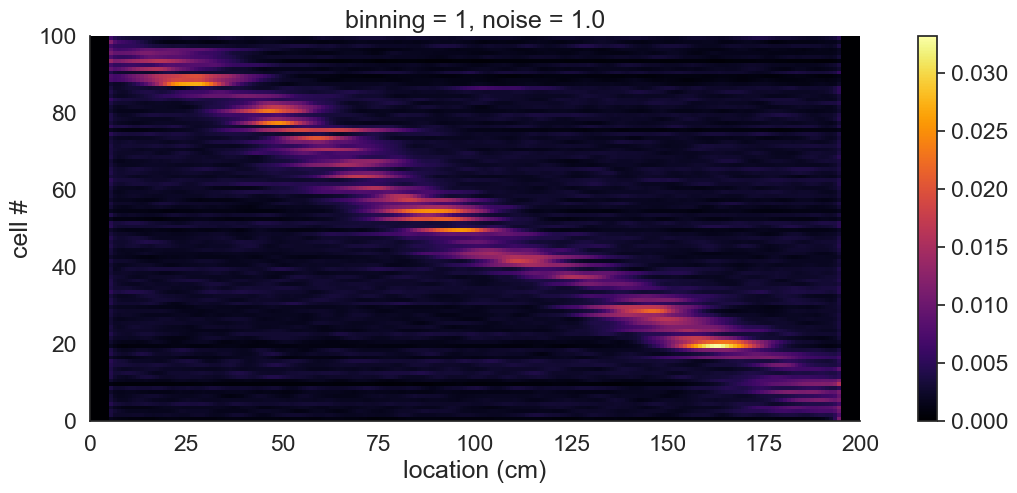

In [6]:
from sklearn.neighbors import KernelDensity

binning = 1 # smaller binning results in smoother densities

for noise in [0.1, 0.5, 1.0]:

    _, spikes, t, x, _ = simulate_data(background_noise=noise, fps = fps, n_cells = n_cells)
    spike_positions = [np.interp(s, t, x) for s in spikes]

    firing_rate_maps, _, space_bins = get_firing_rate_maps(binning, spike_positions, x, n_cells = 200, fps=30) 

    kdes = [KernelDensity(kernel='gaussian', bandwidth=2).fit(spike_positions[i].reshape(-1, 1)) for i in range(n_cells)]
    densities = np.array([np.exp(kdes[i].score_samples(space_bins.reshape(-1, 1))) for i in range(n_cells)])
    densities[:, :5], densities[:,-5:] = 0, 0 # 0 padding on the edges to avoid edge effects due to animal spending most time on edge of track

    plt.figure(figsize=(15,5))
    plt.title(f'binning = {binning}, noise = {noise}')
    peak_locations = firing_rate_maps.argmax(axis=1)
    ix = np.argsort(peak_locations)
    plt.imshow(densities[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()
    plt.show()
    plt.close()



(C) The Gaussian Kernel Density smoothed approximations have peaks at the edges of the track which is due to the animal spending more time there 

In [8]:
noise, binning = 0.1, 5

true_firing_rate_maps, spikes, t, x, pf_centers = simulate_data(background_noise=noise, fps = fps, n_cells = n_cells)
spike_positions = [np.interp(s, t, x) for s in spikes]
firing_rate_maps, occupancy, _ = get_firing_rate_maps(binning, spike_positions, x, n_cells = 200, fps=30) 


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


In [9]:
center_of_mass = [sum(L)/len(L) for L in spike_positions]
mae = np.mean(np.abs(pf_centers-center_of_mass))

print("Mean Absolute Error: ", np.round(mae,3))

Mean Absolute Error:  63.483


(D) The center of mass approximation gives a moderate approximation to the true center of the place fields as defined above.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ 

Where $\epsilon$ is a very small number (e.g. $10^{-15}$) This small number avoids infinities (and NaNs) when $\lambda(x) = 0$.

where $\lambda(x)$ is the firing rate map (as defined above, with some binning precision) $\lambda$ is the average firing rate of the neuron, and $p_{occ}(x)$ is the occupancy as defined above. Information from this formula is expressed in bits per second. An alternative definition is expressed in bits/spike:

$$ I_s = \frac{I}{\lambda}$$ 

(same formula as above divided by average firing rate). This second definition favors low-firing rate cells (typical for place cells)

In [10]:
def mutual_information(firing_rate_maps, occupancy, epsilon = 1e-13):
    """ Mutual information between the firing rate maps and the occupancy map"""
    lda = np.mean(firing_rate_maps, axis = 1)[:,np.newaxis]
    I = np.sum(firing_rate_maps * np.log2((firing_rate_maps + epsilon)/lda) * occupancy, axis = 1) 
    return I, I/lda[:,0]


def simulate_data(peak_firing_rate, pf_size, baseline_noise, fps = 30, n_cells = 100):

    track_length = 200. # the length of our linear track (eg in centimeter)
    average_firing_rate = peak_firing_rate # the peak firing rate, averaged across the population 
    n_cells = n_cells 
    pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
    # pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
    pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

    bins = np.arange(0., 200.)
    true_firing_rate_maps = np.zeros((n_cells, len(bins)))
    for i in range(n_cells):
        true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
        
    n_runs = 20 
    av_running_speed = 10 # the average running speed (in cm/s)
    fps = fps
    running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
    running_speed_b = np.random.chisquare(10, size=n_runs) 

    stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
    stopping_time_b = np.random.chisquare(15, size=n_runs)

    x = np.array([])
    for i in range(n_runs):
        stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
        run_length = len(bins) * fps / running_speed_a[i]
        run1 = np.linspace(0., float(len(bins)-1), int(run_length))
        stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
        run_length = len(bins) * fps / running_speed_b[i]
        run2 = np.linspace(len(bins)-1., 0., int(run_length))
        x = np.concatenate((x, stop1, run1, stop2, run2))
    t = np.arange(len(x))/fps


    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    noise_firing_rate = baseline_noise # the baseline noise firing rate
    spikes = []

    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    binning = 1

    space_bins = np.arange(0., 200., float(binning))

    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)

    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps

    firing_rate_maps = spikes_hist / occupancy 

    return firing_rate_maps, occupancy

I, I_s = mutual_information(firing_rate_maps, occupancy)

In [13]:
n_cells = 100
baseline_noise = 0.1
pf_size = np.random.gamma(10, size=n_cells)
peak_firing_rate = 5
n_cells = len(pf_size)
fps = 30

mis, mis_s = [], []
peak_firing_rates = np.linspace(1,11,5)

for i, peak_firing_rate in enumerate(peak_firing_rates):
    print(i)
    firing_rate_maps, occupancy = simulate_data(peak_firing_rate=peak_firing_rate, pf_size = pf_size,
                                                baseline_noise=baseline_noise, fps = fps, n_cells = n_cells)
    I, I_s = mutual_information(firing_rate_maps, occupancy)
    mis.append(I)
    mis_s.append(I_s)


0


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


1


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


2


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


3


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


4


100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


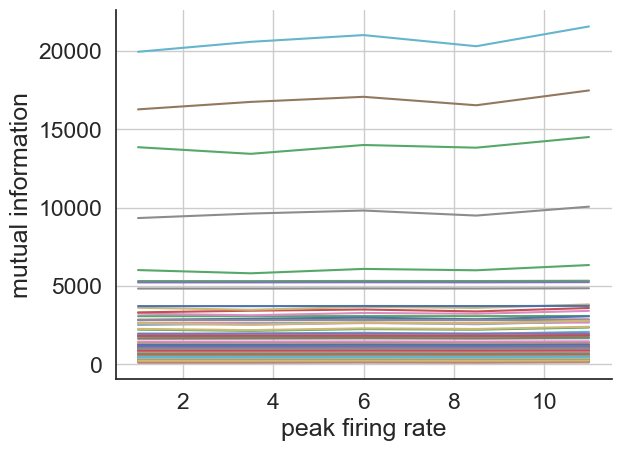

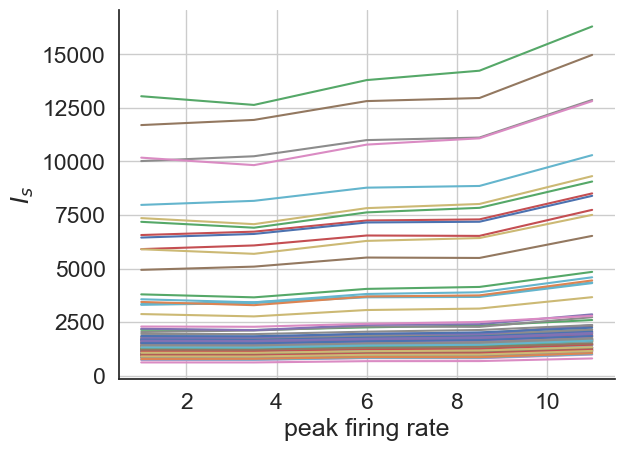

In [14]:

plt.figure()
plt.plot(peak_firing_rates, mis)
plt.xlabel('peak firing rate')
plt.ylabel('mutual information')
plt.grid()
plt.show()

plt.figure()
plt.plot(peak_firing_rates, mis_s)
plt.xlabel('peak firing rate')
plt.ylabel(r'$I_s$')
plt.grid()
plt.show()


0


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


1


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


2


100%|██████████| 100/100 [01:34<00:00,  1.05it/s]


3


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


4


100%|██████████| 100/100 [01:02<00:00,  1.61it/s]


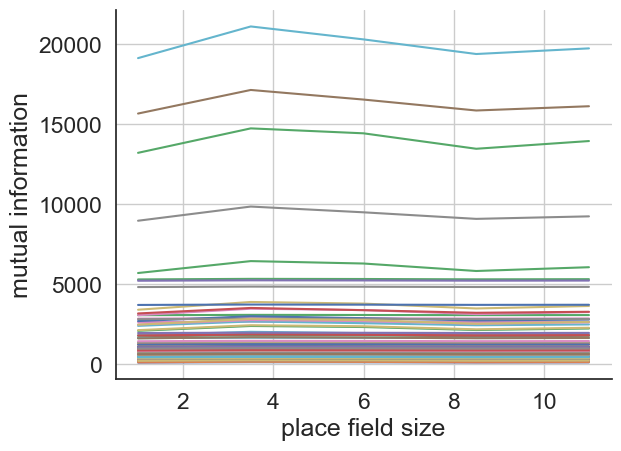

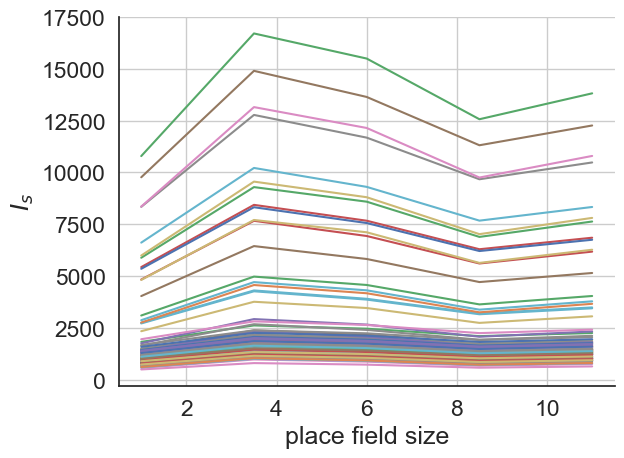

In [15]:
peak_firing_rate = 5

pf_sizes = [np.ones(n_cells)*s for s in np.linspace(1,11,5)]
mis = []

for i, pf_size in enumerate(pf_sizes):
    print(i)
    firing_rate_maps, occupancy = simulate_data(peak_firing_rate=peak_firing_rate, pf_size = pf_size,
                                                baseline_noise=baseline_noise, fps = fps, n_cells = n_cells)
    mis.append(mutual_information(firing_rate_maps, occupancy))

plt.figure()
plt.plot(pf_sizes, [i[0] for i in mis])
plt.xlabel('place field size')
plt.ylabel('mutual information')
plt.grid()
plt.show()

plt.figure()
plt.plot(pf_sizes, [i[1] for i in mis])
plt.xlabel('place field size')
plt.ylabel(r'$I_s$')
plt.grid()
plt.show()

0


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


1


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


2


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


3


100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


4


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


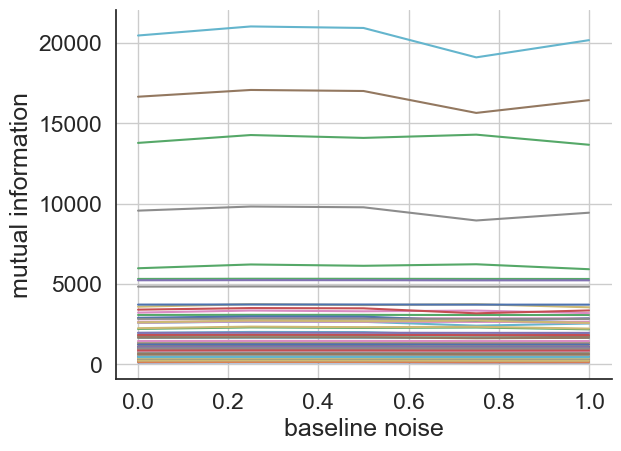

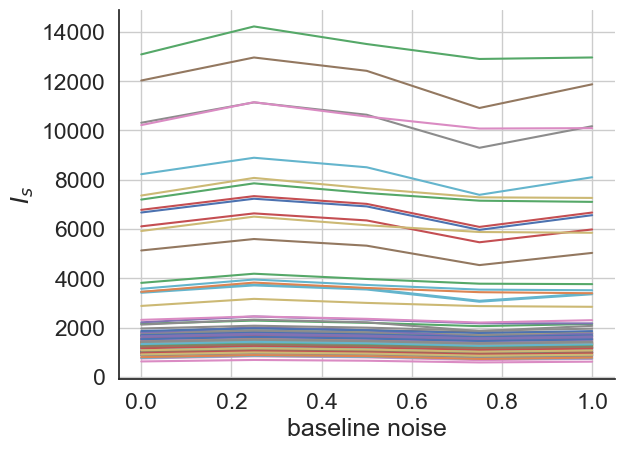

In [16]:
pf_size = np.random.gamma(10, size=n_cells)

mis = []
noise_levels = np.linspace(0,1,5)

for i, baseline_noise in enumerate(noise_levels):
    print(i)
    firing_rate_maps, occupancy = simulate_data(peak_firing_rate=peak_firing_rate, pf_size = pf_size, baseline_noise=baseline_noise,
                                                fps = fps, n_cells = n_cells)
    mis.append(mutual_information(firing_rate_maps, occupancy))

plt.figure()
plt.plot(noise_levels, [i[0] for i in mis])
plt.xlabel('baseline noise')
plt.ylabel('mutual information')
plt.grid()
plt.show()

plt.figure()
plt.plot(noise_levels, [i[1] for i in mis])
plt.xlabel('baseline noise')
plt.ylabel(r'$I_s$')
plt.grid()
plt.show()


Overall, I_s seems to be more informative about the information transmitted by a neuron. It differentiates more particularly between neurons with low mutual information. Moreover, it scales positively with thek firing rate and negatively with place field size. Neither of the measures scales with the baseline noise as long as the noise level is moderate.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

In [17]:
file = open('data/linear_track_data.pickle', 'rb')
data = pickle.load(file)
file.close()

x, times, spikes = data['x'], data['t'], data['spikes']
n_cells = len(spikes)

cell_num = 58 # select single cell for plotting



94.96118975101513


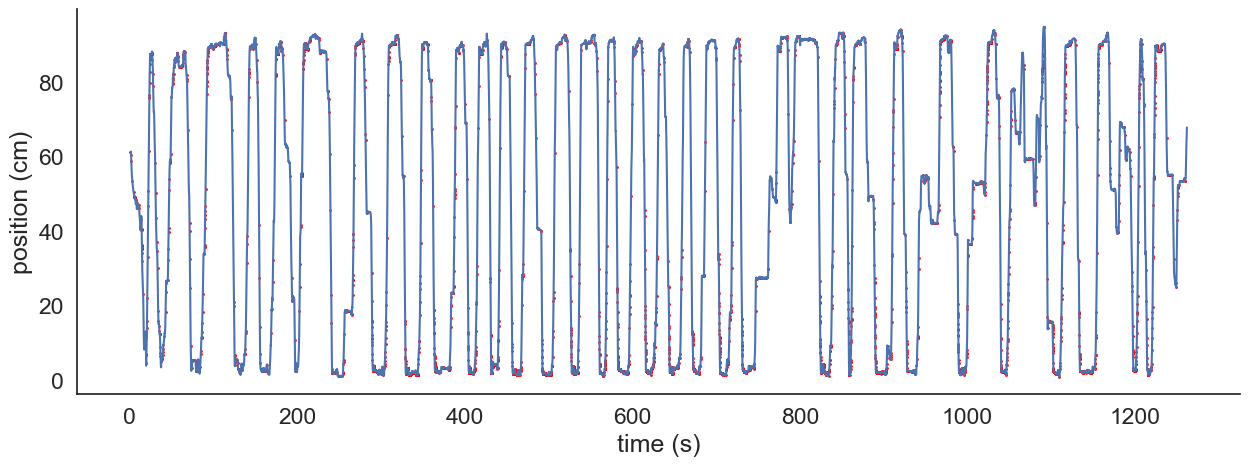

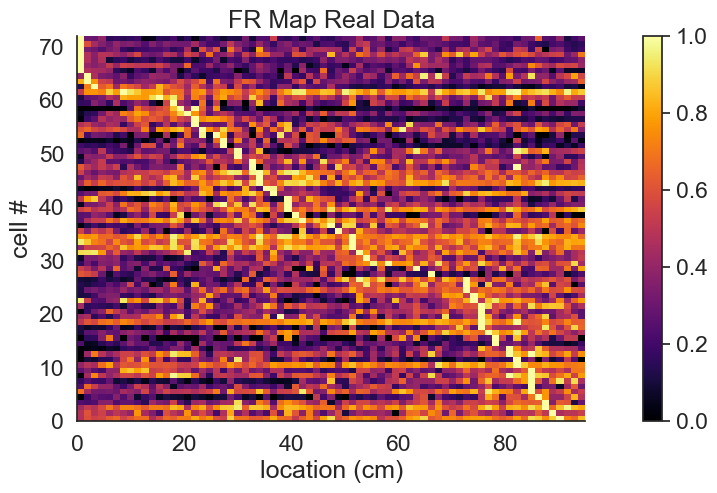

In [18]:

spike_positions = [np.interp(s, times, x) for s in spikes]
spike_times = spikes

plt.figure(figsize=(15,5))
plt.plot(times, x)
plt.scatter(spike_times[cell_num], spike_positions[cell_num], color='red', s=1)
plt.xlabel('time (s)')
plt.ylabel('position (cm)')


binning = 1
fps = 30
track_length = np.max(x)

print(track_length)

firing_rate_maps, occupancy, space_bins = get_firing_rate_maps(binning, spike_positions, x, n_cells, fps=fps)

firing_rate_maps_normalized = firing_rate_maps / np.max(firing_rate_maps, axis = 1)[:,np.newaxis] # normalize for overall firing rate per cell
plot_firing_rate_maps(firing_rate_maps_normalized, n_cells, track_length, title = f'FR Map Real Data')



In [19]:
densities.shape

(100, 200)

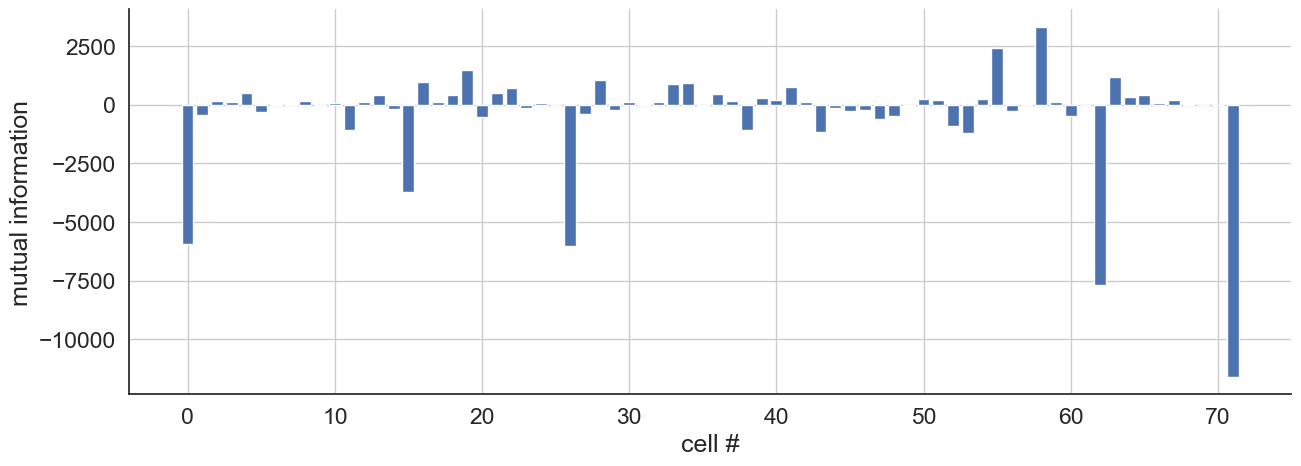

In [20]:
I, I_s = mutual_information(firing_rate_maps, occupancy)


plt.figure(figsize=(15,5))
plt.bar(range(n_cells), I)
plt.xlabel('cell #')
plt.ylabel('mutual information')
plt.grid()
plt.show()


[ 0 15 26 62 71] [19 28 55 58 63]


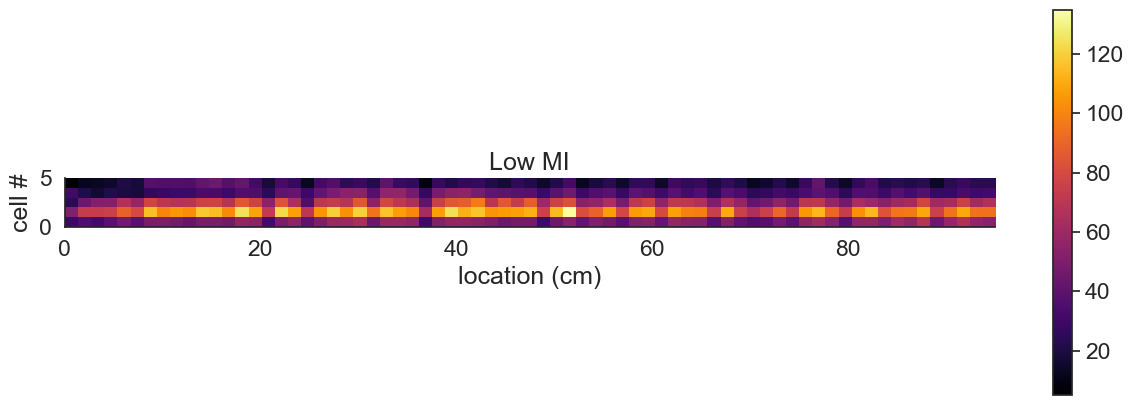

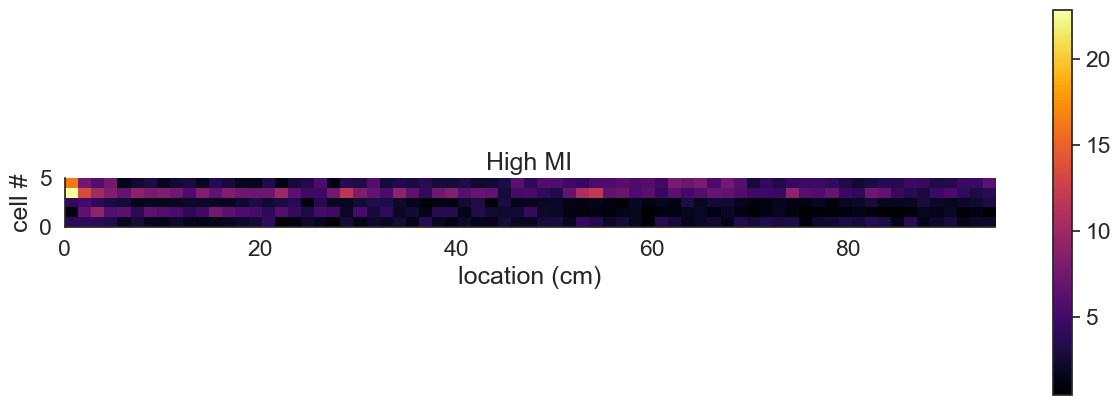

[ 80.14411143  74.00307626  83.24936088 185.07698829 310.05470996] [4.93889297 0.77114338 8.37666621 4.22997037 0.74812088]


In [21]:
I_sorted = I.copy()
I_sorted = np.sort(I_sorted)
I_low, I_high = I_sorted[:5], I_sorted[-5:]

low_I_cells = np.argwhere(I <= I_low[-1]).flatten()
high_I_cells = np.argwhere(I >= I_high[0]).flatten()

print(low_I_cells, high_I_cells)

plot_firing_rate_maps(firing_rate_maps[low_I_cells], n_cells = len(low_I_cells), track_length = track_length, title = "Low MI")

plot_firing_rate_maps(firing_rate_maps[high_I_cells], n_cells = len(high_I_cells), track_length = track_length,  title = "High MI")



The cells with low spatial information have low spatial specificity while those with high spatial information respond rather specifically to specific locations.